In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# XGBoost on RNA Seq Data

In [ ]:
#/content/drive/MyDrive/cancer-dataset

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split    
from sklearn.metrics import mean_squared_error
#from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import seaborn as sb


In [4]:

df = pd.read_csv("/content/drive/MyDrive/cancer-dataset/TCGA-HNSC.htseq_fpkm-ext/TCGA-HNSC.htseq_fpkm.tsv", delimiter = '\t' , engine='python')


In [5]:
#df.head()

In [6]:

df2 = pd.read_csv("/content/drive/MyDrive/cancer-dataset/TCGA-THCA.htseq_fpkm.tsv", delimiter = '\t' , engine='python')
df3 = pd.read_csv("/content/drive/MyDrive/cancer-dataset/TCGA-ESCA.htseq_fpkm.tsv", delimiter = '\t' , engine='python')


In [ ]:
df_concat = pd.concat([df, df2,df3], axis=1)
#df_concat.head()
df_concat.to_csv("/content/drive/MyDrive/cancer-dataset/dataset-with-names.csv", sep=',')

In [ ]:
df_concat.info()

In [ ]:
df_concat.describe()

In [ ]:
df_concat.isnull().sum()

The TCGA dataset contains 2 types of patient gene expression data - primary tumour and solid normal. This is distinguished by the Patient ID. 

In [ ]:
patientId = list(df_concat.columns)
targetPatientId  = patientId[:546]
normalPatient = []
del(targetPatientId[0])
for id in targetPatientId:
     name = id.split('-')
     sampleId  = name[-1]
     if sampleId[0] == "1":
  	    #print("primary tumour")
          normalPatient.append(id)

normalPatient[2] #test case

Removing the column and row names as pre-step to feed into the XGBoost model.


In [ ]:
data=df_concat.drop(['Ensembl_ID'], axis=1)
#data.head()

In [ ]:
data

In [ ]:
data_T = data.transpose()
print(data_T.shape)
data_T = data_T.iloc[: , :]
#data_T.head()

In [ ]:
fig, ax = plt.subplots(figsize=(11, 9))
sb.heatmap(data_T)
plt.show()

In [ ]:
del(data)

Primary tumour samples of HNSC are assigned target label 1 and the rest are assigned 0, including HNSC solid normal

In [ ]:
data_T['target'] = 0
#print(data_T.shape)
data_T.iloc[:546,-1] = 1
for patient in normalPatient:
    data_T.loc[patient, 'target'] = 0
data_T.loc['TCGA-CV-7242-11A','target']

data_T.to_csv("/content/drive/MyDrive/cancer-dataset/combined-dataframe.csv", sep=',')

In [ ]:
X = data_T.iloc[:,:60483]
X.reset_index(drop=True, inplace=True)
#X.head()

In [ ]:
y = data_T[['target']]
y.reset_index(drop=True, inplace=True)
#y.head()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
from sklearn.metrics import log_loss

Training a base level XGboost Classifer.
K-fold =5, early stopping of 10 rounds gives mean accuracy of 99.22%

In [ ]:
reg_xgb = xgb.XGBClassifier(objective='binary:logistic',seed=42)
reg_xgb.fit(
    X_train,
           y_train,
           verbose=True,
            early_stopping_rounds=10,
            eval_set=[(X_test,y_test)]        
)

kfold = KFold(n_splits=5,)
results = cross_val_score(reg_xgb, X_train, y_train, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
from sklearn.metrics import classification_report
pred = reg_xgb.predict(X_test)
print(classification_report(y_test, pred))

In [ ]:
params={
 "learning_rate"    : [ 0.05, 0.10, 0.20] ,
 "max_depth"        : [ 2,5],
 "min_child_weight" : [ 3, 5],
 "gamma"            : [0,0.1,0.5,1],
 #"colsample_bytree" : [ 0.3, 0.4, 0.5],
  "reg_lambda"      : [0,0.5,1],
    #"subsample"     : [0.7,0.8],

}

In [ ]:
optimal_params = RandomizedSearchCV(
estimator = xgb.XGBRegressor(objective='binary:logistic',seed=42,
                             verbose=0,cv=5,
                             colsample_bytree= 0.4
                            ),
    param_distributions=params,
    n_iter=10,
    n_jobs=-1,
    verbose=0,
    cv=5
                              
)

In [ ]:
optimal_params.fit(X_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_set=[(X_test,y_test)],
                    verbose=True)

#print(optimal_params.best_params_)

In [ ]:
import shap
explainer = shap.Explainer(reg_xgb, X)
shap_values = explainer(X[:1000])

{'2764 ': 501.47350459999996, '409  ': 25.185325624999997, '8652 ': 21.3118248, '6    ': 0.465148926, '7864 ': 56.45572896, '33507': 44.40759786666666, '2    ': 0.0232200623, '29   ': 0.125701904, '22200': 84.0702362, '30513': 45.7835541, '35   ': 0.262359619, '60258': 71.0875092, '93   ': 0.37588501, '53850': 16.9541016, '7777 ': 8.07211304, '4    ': 0.277322769, '32085': 33.230423, '42054': 69.0208905125, '34204': 41.166214000000004, '19274': 8.515640265, '28113': 9.35711577, '40221': 13.53997991, '44719': 26.246979974545447, '46385': 119.09572096666665, '20282': 19.1125336, '37955': 9.72010803, '11417': 8.94367981, '22506': 10.3392944, '28687': 111.22231665, '27340': 11.70964815, '2344 ': 3.40917969, '40800': 5.221677143333333, '28595': 16.1873169, '27620': 2.581604, '25027': 9.53961563, '10392': 2.0428772, '9287 ': 29.9938717, '17563': 10.8470917, '21075': 3.92970657, '36991': 12.335830699999999, '7324 ': 3.6612885, '17652': 4.465003965, '45440': 5.344964985000001, '11915': 0.39042

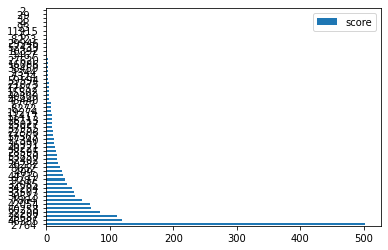

In [ ]:
Imp_feature = reg_xgb.get_booster().get_score(importance_type = 'gain')
print(Imp_feature)
keys = list(Imp_feature.keys())
print(keys)
values = list(Imp_feature.values())


#values_sort = sorted(values)
#print(values_sort)

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

#Imp_feature = list(Imp_feature.keys())
print(len(Imp_feature))

In [ ]:
t = pd.DataFrame(Imp_feature, index = [0])
t.head()
t.to_csv("/content/drive/MyDrive/cancer-dataset/gene-feature-xgboost-corrected.csv", sep=',')

In [ ]:
print(sorted(Imp_feature.items(),reverse=True, key =
             lambda kv:(kv[1], kv[0])))

[('2764 ', 501.47350459999996), ('46385', 119.09572096666665), ('28687', 111.22231665), ('22200', 84.0702362), ('60258', 71.0875092), ('42054', 69.0208905125), ('7864 ', 56.45572896), ('30513', 45.7835541), ('33507', 44.40759786666666), ('34204', 41.166214000000004), ('32085', 33.230423), ('9287 ', 29.9938717), ('44719', 26.246979974545447), ('409  ', 25.185325624999997), ('8652 ', 21.3118248), ('20282', 19.1125336), ('52402', 17.799795166666666), ('53850', 16.9541016), ('28595', 16.1873169), ('40221', 13.53997991), ('36991', 12.335830699999999), ('27340', 11.70964815), ('17563', 10.8470917), ('22506', 10.3392944), ('37955', 9.72010803), ('25027', 9.53961563), ('28113', 9.35711577), ('11417', 8.94367981), ('19274', 8.515640265), ('8272 ', 8.27612972), ('7777 ', 8.07211304), ('45440', 5.344964985000001), ('40800', 5.221677143333333), ('15502', 4.47951126), ('17652', 4.465003965), ('21075', 3.92970657), ('59594', 3.77126312), ('7324 ', 3.6612885), ('2344 ', 3.40917969), ('38459', 2.72111

In [ ]:
del(dn)

In [ ]:
df_concat.iloc[2764,:]

Ensembl_ID          ENSG00000074800.12
TCGA-HD-7831-01A               8.43974
TCGA-H7-7774-01A               8.74896
TCGA-CV-6943-01A               8.82354
TCGA-CN-5374-01A               9.33407
                           ...        
TCGA-IG-A6QS-01A               8.80582
TCGA-L5-A4OO-01A               7.08188
TCGA-VR-AA7I-01A               7.95569
TCGA-L5-A4OW-01A                7.3107
TCGA-2H-A9GQ-01A               7.52445
Name: 2764, Length: 1290, dtype: object

In [ ]:
df_concat.iloc[46385,:]

Ensembl_ID          ENSG00000207296.1
TCGA-HD-7831-01A              3.83193
TCGA-H7-7774-01A              3.79003
TCGA-CV-6943-01A              2.62391
TCGA-CN-5374-01A             0.680515
                          ...        
TCGA-IG-A6QS-01A              1.17754
TCGA-L5-A4OO-01A             0.842916
TCGA-VR-AA7I-01A              4.10919
TCGA-L5-A4OW-01A              1.54533
TCGA-2H-A9GQ-01A                    0
Name: 46385, Length: 1290, dtype: object

In [ ]:
perm_importance = permutation_importance(xgb, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(boston.feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")